#Advanced Machine Learning - Assignment #1
## BBC News Category Classification Mini-Hackathon
Cheng Man  
2020/05/07






### Description of the dataset
---
For this BBC dataset, every single row represents a news article from BBC. The dataset has two columns: `category`(which category the article is belong) and `text`(the raw text in the article). There are 2,225 articles in the dataset from 5 categories: tech, business, sport, entertainment and politics.  

In [5]:
import pandas as pd
df = pd.read_csv("https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv")
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


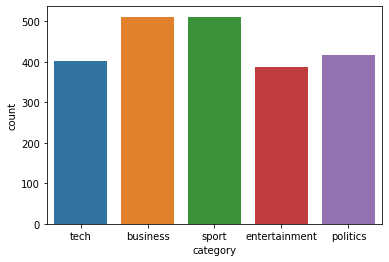

In [20]:
# Visualization the category variable
import seaborn as sns

sns.countplot(df['category'])

In [22]:
df['text'][0]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

### Data Preprocessing

In [0]:
X = df['text']
y = df['category']

In [18]:
# Tokenize the data into one hot vectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X) # converts words in each text to each word's numeric index in tokenizer dictionary.

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=maxlen)

y = np.asarray(y)

print('Shape of text tensor:', X.shape)
print('Shape of category tensor:', y.shape)

# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)
print('Shape of X_train', X_train.shape)
print('Shape of X_test', X_test.shape)
print('Shape of y_train', y_train.shape)
print('Shape of y_test', y_test.shape)


Found 29726 unique tokens.
Shape of text tensor: (2225, 100)
Shape of category tensor: (2225,)
Shape of X_train (1668, 100)
Shape of X_test (557, 100)
Shape of y_train (1668,)
Shape of y_test (557,)


### Build Models

#### Model #1: A model with an embedding layer and dense layers (but w/ no layers meant for sequential data)

In [121]:
from keras.layers import Dense, Embedding
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.optimizers import RMSprop

model1 = Sequential()
model1.add(Embedding(max_words, 32, input_length=maxlen))
model1.add(Flatten())
model1.add(Dense(5, activation='softmax'))
model1.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])
model1.summary()

history = model1.fit(X_train, pd.get_dummies(y_train), epochs=24, batch_size=128)

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_48 (Embedding)     (None, 100, 32)           320000    
_________________________________________________________________
flatten_18 (Flatten)         (None, 3200)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 5)                 16005     
Total params: 336,005
Trainable params: 336,005
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/24
1668/1668 [==============================] - 0s 84us/step - loss: 1.6009 - acc: 0.2632
Epoch 2/24
1668/1668 [==============================] - 0s 56us/step - loss: 1.5071 - acc: 0.7188
Epoch 3/24
1668/1668 [==============================] - 0s 53us/step - loss: 1.4190 - acc: 0.7650
Epoch 4/24
1668/1668 [==============================] - 0s 61us/step - loss: 1.3067 - acc: 0.8627
Epoch 5/24
1668/1668 [==============================] - 0s 62us/step - loss: 1.1623 - acc: 0.9239
Epoch 6/24
1668/1668 [==============================] - 0s 52us/step - loss: 0.9953 - acc: 0.9610
Epoch 7/24
1668/1668 [==============================] - 0s 55us/step - loss: 0.8162 - acc: 0.9790
Epoch 8/24
1668/1668 [==============================] - 0s 57us/step - loss: 0.6451 - acc: 0.9904
Epoch 9/24
1668/1668 [==============================] - 0s 56us/step - loss: 0.4953 - acc: 0.9964
Epoch 10/24
1668/1668 [==============================] - 0s 76us/step - loss: 0.3688 - acc: 0.9982
Epoch 11/24
1668/16

In [122]:
result1 = model1.evaluate(X_test, pd.get_dummies(y_test))
print('Test loss, Test acc:', result1)

557/557 [==============================] - 0s 73us/step
Test loss, Test acc: [0.3129880689418937, 0.9012567400932312]


#### Model #2: A model using an Embedding layer with Conv1d Layers

In [123]:
from keras import layers

model2 = Sequential()
model2.add(Embedding(max_words, 32, input_length=maxlen))
model2.add(layers.Conv1D(64, 10, activation='relu')) 
model2.add(layers.GlobalMaxPooling1D())
model2.add(Dense(5, activation='softmax'))
model2.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])
model2.summary()

history = model2.fit(X_train, pd.get_dummies(y_train), epochs=24, batch_size=128)

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_49 (Embedding)     (None, 100, 32)           320000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 91, 64)            20544     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 64)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 5)                 325       
Total params: 340,869
Trainable params: 340,869
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/24
1668/1668 [==============================] - 1s 450us/step - loss: 1.5957 - acc: 0.2866
Epoch 2/24
1668/1668 [==============================] - 1s 382us/step - loss: 1.5426 - acc: 0.3267
Epoch 3/24
1668/1668 [==============================] - 1s 375us/step - loss: 1.4970 - acc: 0.4538
Epoch 4/24
1668/1668 [==============================] - 1s 393us/step - loss: 1.4388 - acc: 0.4916
Epoch 5/24
1668/1668 [==============================] - 1s 387us/step - loss: 1.3599 - acc: 0.5462
Epoch 6/24
1668/1668 [==============================] - 1s 392us/step - loss: 1.2618 - acc: 0.5641
Epoch 7/24
1668/1668 [==============================] - 1s 386us/step - loss: 1.1521 - acc: 0.6229
Epoch 8/24
1668/1668 [==============================] - 1s 368us/step - loss: 1.0377 - acc: 0.7326
Epoch 9/24
1668/1668 [==============================] - 1s 369us/step - loss: 0.9217 - acc: 0.8381
Epoch 10/24
1668/1668 [==============================] - 1s 361us/step - loss: 0.8038 - acc: 0.8903
Epoch 11/

In [124]:
result2 = model2.evaluate(X_test, pd.get_dummies(y_test))
print('Test loss, Test acc:', result2)

557/557 [==============================] - 0s 184us/step
Test loss, Test acc: [0.2774705849119748, 0.9192100763320923]


#### Model #3: A model using an Embedding layer with one sequential layer (LSTM or GRU)

In [125]:
model3 = Sequential()
model3.add(Embedding(max_words, 32, input_length=maxlen))
model3.add(layers.LSTM(32))
model3.add(Dense(5, activation='softmax'))
model3.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])
model3.summary()

history = model3.fit(X_train, pd.get_dummies(y_train), epochs=24, batch_size=128)

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_50 (Embedding)     (None, 100, 32)           320000    
_________________________________________________________________
lstm_35 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_46 (Dense)             (None, 5)                 165       
Total params: 328,485
Trainable params: 328,485
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/24
1668/1668 [==============================] - 1s 887us/step - loss: 1.6032 - acc: 0.2230
Epoch 2/24
1668/1668 [==============================] - 1s 723us/step - loss: 1.4572 - acc: 0.3261
Epoch 3/24
1668/1668 [==============================] - 1s 738us/step - loss: 1.2226 - acc: 0.4418
Epoch 4/24
1668/1668 [==============================] - 1s 749us/step - loss: 1.1438 - acc: 0.4299
Epoch 5/24
1668/1668 [==============================] - 1s 741us/step - loss: 1.0718 - acc: 0.4269
Epoch 6/24
1668/1668 [==============================] - 1s 752us/step - loss: 1.0338 - acc: 0.4430
Epoch 7/24
1668/1668 [==============================] - 1s 740us/step - loss: 0.9811 - acc: 0.5114
Epoch 8/24
1668/1668 [==============================] - 1s 731us/step - loss: 0.9547 - acc: 0.5168
Epoch 9/24
1668/1668 [==============================] - 1s 735us/step - loss: 0.9116 - acc: 0.6145
Epoch 10/24
1668/1668 [==============================] - 1s 728us/step - loss: 0.8679 - acc: 0.6469
Epoch 11/

In [126]:
result3 = model3.evaluate(X_test, pd.get_dummies(y_test))
print('Test loss, Test acc:', result3)

557/557 [==============================] - 0s 411us/step
Test loss, Test acc: [0.6251243842996429, 0.7845601439476013]


#### Model #4: A model using an Embedding layer with stacked sequential layers (LSTM or GRU)

In [127]:
model4 = Sequential()
model4.add(Embedding(max_words, 32, input_length=maxlen))
model4.add(layers.LSTM(32, return_sequences=True))
model4.add(layers.LSTM(32, return_sequences=True))
model4.add(layers.LSTM(32))
model4.add(Dense(5, activation='softmax'))
model4.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])
model4.summary()

history = model4.fit(X_train, pd.get_dummies(y_train), epochs=24, batch_size=128)

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_51 (Embedding)     (None, 100, 32)           320000    
_________________________________________________________________
lstm_36 (LSTM)               (None, 100, 32)           8320      
_________________________________________________________________
lstm_37 (LSTM)               (None, 100, 32)           8320      
_________________________________________________________________
lstm_38 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_47 (Dense)             (None, 5)                 165       
Total params: 345,125
Trainable params: 345,125
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/24
1668/1668 [==============================] - 4s 3ms/step - loss: 1.6069 - acc: 0.2974
Epoch 2/24
1668/1668 [==============================] - 3s 2ms/step - loss: 1.1835 - acc: 0.4592
Epoch 3/24
1668/1668 [==============================] - 4s 2ms/step - loss: 0.9062 - acc: 0.6205
Epoch 4/24
1668/1668 [==============================] - 4s 2ms/step - loss: 0.6935 - acc: 0.7326
Epoch 5/24
1668/1668 [==============================] - 3s 2ms/step - loss: 0.5284 - acc: 0.8435
Epoch 6/24
1668/1668 [==============================] - 3s 2ms/step - loss: 0.4242 - acc: 0.8933
Epoch 7/24
1668/1668 [==============================] - 3s 2ms/step - loss: 0.2618 - acc: 0.9532
Epoch 8/24
1668/1668 [==============================] - 3s 2ms/step - loss: 0.2191 - acc: 0.9502
Epoch 9/24
1668/1668 [==============================] - 3s 2ms/step - loss: 0.1659 - acc: 0.9628
Epoch 10/24
1668/1668 [==============================] - 3s 2ms/step - loss: 0.1658 - acc: 0.9568
Epoch 11/24
1668/1668 [======

In [128]:
result4 = model4.evaluate(X_test, pd.get_dummies(y_test))
print('Test loss, Test acc:', result4)

557/557 [==============================] - 1s 1ms/step
Test loss, Test acc: [0.7646031503095768, 0.8473967909812927]


#### Model #5: A model using an Embedding layer with bidirectional sequential layers

In [129]:
model5 = Sequential()
model5.add(Embedding(max_words, 32, input_length=maxlen))
model5.add(layers.Bidirectional(layers.LSTM(32)))
model5.add(Dense(5, activation='softmax'))
model5.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])
model5.summary()

history = model5.fit(X_train, pd.get_dummies(y_train), epochs=24, batch_size=128)

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_52 (Embedding)     (None, 100, 32)           320000    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 64)                16640     
_________________________________________________________________
dense_48 (Dense)             (None, 5)                 325       
Total params: 336,965
Trainable params: 336,965
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/24
1668/1668 [==============================] - 3s 2ms/step - loss: 1.6000 - acc: 0.2740
Epoch 2/24
1668/1668 [==============================] - 2s 1ms/step - loss: 1.5645 - acc: 0.3963
Epoch 3/24
1668/1668 [==============================] - 2s 1ms/step - loss: 1.3405 - acc: 0.5042
Epoch 4/24
1668/1668 [==============================] - 2s 1ms/step - loss: 0.9620 - acc: 0.6757
Epoch 5/24
1668/1668 [==============================] - 2s 1ms/step - loss: 0.8163 - acc: 0.6367
Epoch 6/24
1668/1668 [==============================] - 2s 1ms/step - loss: 0.7609 - acc: 0.6247
Epoch 7/24
1668/1668 [==============================] - 2s 1ms/step - loss: 0.6717 - acc: 0.6882
Epoch 8/24
1668/1668 [==============================] - 2s 1ms/step - loss: 0.6120 - acc: 0.7488
Epoch 9/24
1668/1668 [==============================] - 2s 1ms/step - loss: 0.5631 - acc: 0.8291
Epoch 10/24
1668/1668 [==============================] - 2s 1ms/step - loss: 0.4813 - acc: 0.9305
Epoch 11/24
1668/1668 [======

In [139]:
result5 = model5.evaluate(X_test, pd.get_dummies(y_test))
print('Test loss, Test acc:', result5)

557/557 [==============================] - 0s 491us/step
Test loss, Test acc: [0.4640356521632128, 0.8868940472602844]


#### Model #6: Retrain Model #5(bidirectional) with dropout(Model #5 is the best model among Model #3-5, which has lower test loss and higher test accuracy)

In [137]:
model6 = Sequential()
model6.add(Embedding(max_words, 32, input_length=maxlen))
model6.add(layers.Bidirectional(layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2))) 
model6.add(Dense(5, activation='softmax'))
model6.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])
model6.summary()

history = model6.fit(X_train, pd.get_dummies(y_train), epochs=36, batch_size=128)

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_56 (Embedding)     (None, 100, 32)           320000    
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 64)                16640     
_________________________________________________________________
dense_52 (Dense)             (None, 5)                 325       
Total params: 336,965
Trainable params: 336,965
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/36
1668/1668 [==============================] - 3s 2ms/step - loss: 1.6005 - acc: 0.2542
Epoch 2/36
1668/1668 [==============================] - 2s 1ms/step - loss: 1.5582 - acc: 0.2800
Epoch 3/36
1668/1668 [==============================] - 2s 1ms/step - loss: 1.3734 - acc: 0.5126
Epoch 4/36
1668/1668 [==============================] - 2s 1ms/step - loss: 1.1472 - acc: 0.5839
Epoch 5/36
1668/1668 [==============================] - 2s 1ms/step - loss: 1.0643 - acc: 0.6013
Epoch 6/36
1668/1668 [==============================] - 2s 1ms/step - loss: 1.0022 - acc: 0.6253
Epoch 7/36
1668/1668 [==============================] - 2s 1ms/step - loss: 1.0094 - acc: 0.5965
Epoch 8/36
1668/1668 [==============================] - 2s 1ms/step - loss: 0.9826 - acc: 0.6289
Epoch 9/36
1668/1668 [==============================] - 2s 1ms/step - loss: 0.9737 - acc: 0.6121
Epoch 10/36
1668/1668 [==============================] - 2s 1ms/step - loss: 0.8676 - acc: 0.6631
Epoch 11/36
1668/1668 [======

In [138]:
result6 = model6.evaluate(X_test, pd.get_dummies(y_test))
print('Test loss, Test acc:', result6)

557/557 [==============================] - 0s 814us/step
Test loss, Test acc: [0.44903707680839183, 0.8815080523490906]


### Further Discussion
---
#### 1. In this project, the best model is Model #2, which uses an Embedding layer with Conv1d Layers.  
#### 2. For further improving my model, I think there are several ways, including
1) **Use Glove embedding matrix weights.**Words not found in Glove embedding index will be all-zeros.   
2) **Add more layers to increase the depth of the model**, making the model more accurately earning the description as a deep learning technique.  
3) **Combining different kinds of layers in one single model**, in order to make the model more comprehensive.  


#### The url of public repo on Github: https://github.com/3scman/Adv_ML_Repo_ChengMan/tree/master/HW03